# Advanced ML Project
---

## Summary

1. **Transformers with Attention Mechanisms**
    - **Project**: Develop a specialized Transformer model to capture long-term dependencies and temporal relationships in financial data, based on "Attention is All You Need" by Vaswani et al. (2017). We could also use the Temporal Fusion Transformer (TFT) for its efficiency with multi-horizon series, as presented by Lim et al. in "Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting" (2021).
    - **Objective**: Improve prediction accuracy by using attention mechanisms to capture the influences of distant data points.

2. **Variational Autoencoders (VAE) for Feature Engineering and Anomaly Detection**
    - **Project**: Use VAEs to compress market data and extract latent representations less sensitive to noise, inspired by "Auto-Encoding Variational Bayes" by Kingma and Welling (2013). We will also explore VAE-based approaches for anomaly detection in time series, as detailed in "Robust Anomaly Detection for Multivariate Time Series through Stochastic Recurrent Neural Network" by Hundman et al. (2018).
    - **Objective**: Extract robust latent features and detect anomalies to improve predictions and identify unexpected market variations.

3. **Performance Comparison**
    - **Objective**: Compare the performance of the two methods (Transformers vs VAE) for time series forecasting.

4. **Hyperparameter Fine-Tuning**
    - **Objective**: Fine-tune the model hyperparameters to optimize prediction performance.

https://github.com/xuxu-wei/HybridVAE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from transformers import TimeSeriesTransformerForPrediction
#from lightning.pytorch import Trainer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.metrics import QuantileLoss, MAE
from pytorch_forecasting.data import GroupNormalizer
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.loggers import TensorBoardLogger


/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

In [112]:
df = pd.read_parquet('../preprocessed_data/training.parquet').dropna()
val_df = pd.read_parquet('../preprocessed_data/validation.parquet')

In [113]:
df.drop(columns="responder_6_lag_1", inplace=True)

In [122]:
# Samples to try the algo
df_small = df.iloc[-50000:]
val_df_small = val_df.sample(10000)

In [123]:
df_small

,id,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,...,responder_8,label,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_7_lag_1,responder_8_lag_1
4917242,46545372,1683,540,38,3.273693,3.556780,0.074575,2.914518,2.453409,0.463120,...,0.277686,0,-0.028175,-0.080025,2.841541,-0.226218,-0.121201,1.421510,-0.036155,-0.272156
4917243,46545373,1683,541,0,2.701212,3.372633,-0.374773,2.995247,3.278934,0.005105,...,-0.046610,0,-0.393132,-0.275410,1.151608,0.406872,0.187856,0.207768,0.045769,0.080846
4917244,46545374,1683,541,1,2.063448,3.227684,-0.334587,3.511540,3.150932,0.032244,...,0.031631,0,0.800587,0.535868,0.240538,0.232264,0.114425,-0.162787,-0.066659,-0.548071
4917245,46545375,1683,541,2,2.165114,3.412851,-0.185964,2.846127,3.366333,-0.106998,...,0.255572,2,-1.639018,-0.554432,0.467550,0.073211,0.056951,-0.291103,-0.084555,-0.619661
4917246,46545376,1683,541,3,1.990278,3.259458,-0.162744,3.137269,2.922108,0.421853,...,-0.291902,0,-0.653854,-0.178390,-1.439600,-0.949737,-0.427413,-0.794832,-0.048749,-0.196539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4971642,46599772,1684,967,33,1.260113,2.854824,-0.182001,3.030202,2.955101,-0.034863,...,-0.662478,0,1.421281,0.680279,0.839948,0.411006,0.187644,0.273078,-0.016302,-0.182008
4971643,46599773,1684,967,34,2.364175,3.328318,0.004640,3.429580,2.893713,0.575843,...,-0.915839,0,0.557703,0.091131,-0.555067,-0.374748,-0.135764,-0.168106,0.041251,0.005263
4971644,46599774,1684,967,35,0.971465,3.334346,-0.092881,3.382863,3.111636,0.644229,...,0.359975,0,0.923129,0.792256,-0.687760,0.040876,0.033282,0.122405,0.026679,-0.025678
4971646,46599776,1684,967,37,1.306336,3.129787,-0.023663,3.379802,3.387269,0.109540,...,-0.646123,0,0.568908,0.304786,-0.029890,1.104309,0.650506,0.459980,-0.007395,-0.160535


In [169]:
max_encoder_length = 50  # lookback window
max_prediction_length = 5  # forecast window
#training_cutoff = int(len(df) * 0.8)

In [125]:
df_small["symbol_id"] = df_small["symbol_id"].astype("str")
val_df_small["symbol_id"] = val_df_small["symbol_id"].astype("str")

/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_82790/3826929958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small["symbol_id"] = df_small["symbol_id"].astype("str")


In [73]:
df_small.dtypes

id                    uint32
date_id                int32
time_id                int16
symbol_id             object
weight               float32
                      ...   
responder_5_lag_1    float32
responder_6_lag_1    float32
responder_7_lag_1    float32
responder_8_lag_1    float32
time_idx               int16
Length: 104, dtype: object

## Benchmark linear regression

In [133]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [134]:
df_small = df.dropna().sample(1000000)

In [101]:
df_small

,id,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,...,label,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
2128308,43756438,1608.0,364,0,3.937173,2.306764,0.519196,2.637494,2.254404,-0.841473,...,0.0,-0.162277,-0.116389,1.560023,0.979339,0.343606,0.846384,0.210039,0.088136,0.334838
1714380,43342510,1597.0,109,0,4.475202,-0.058088,-2.612298,-0.046534,0.057987,-1.318175,...,0.0,1.592873,1.349861,0.034853,1.579569,0.825219,1.455915,0.738635,0.376521,1.107516
2649701,44277831,1622.0,364,5,3.011554,1.774683,-1.365354,1.586449,1.855868,0.517707,...,0.0,1.264722,0.778407,-0.526852,0.241921,0.177216,0.372287,0.144821,0.096059,0.245909
3989011,45617141,1658.0,518,9,1.194727,1.728448,0.056828,2.213796,2.091799,-1.545495,...,0.0,-0.106015,0.136787,0.622785,0.089944,0.067552,-0.290040,-1.256863,-0.516847,-3.350451
3119651,44747781,1634.0,838,17,3.891044,0.739156,0.923295,0.571764,0.298341,-0.360414,...,0.0,-0.615973,-0.177908,-0.086522,-0.439819,-0.191102,-0.016968,-0.371733,-0.204741,-0.872424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080413,44708543,1633.0,800,13,2.670314,0.455579,0.923407,0.319387,0.632010,0.082968,...,3.0,0.327784,0.268779,1.165349,0.699005,0.443276,1.196272,0.697565,0.234190,1.262335
963786,42591916,1576.0,884,30,2.354905,2.320300,-1.297566,2.499391,2.726670,1.380740,...,0.0,1.309887,0.979838,1.944776,0.420354,0.166707,-0.033193,-0.340363,-0.069098,-0.533852
4448471,46076601,1670.0,828,24,1.294774,-0.114172,-1.025281,0.161494,0.267733,-1.050663,...,0.0,0.376283,-0.302141,-0.045680,0.456144,0.184020,-0.004782,-0.003736,0.015292,-0.024052
2291974,43920104,1612.0,706,26,1.639267,2.598802,-1.028428,1.620213,1.803322,-0.750055,...,0.0,0.428165,0.269177,0.118191,-0.301266,-0.128761,-0.843805,-0.831479,-0.384089,-1.556916


In [135]:
model = LinearRegression()
model.fit(df_small.drop(columns=["label"]), df_small["label"])

LinearRegression()

In [136]:
val_index = [e for e in df.index if e not in df_small.index]
df_val = df.loc[val_index].dropna().sample(100000)

In [137]:
r_sq = model.score(df_small.drop(columns=["label"]), df_small["label"])
print('coefficient of determination:', r_sq)

coefficient of determination: 0.9071758644357212


In [138]:
y_pred = model.predict(df_val.drop(columns=["label"]))
rms = mean_squared_error(df_val["label"], y_pred)

In [144]:
rms

0.1493276222104628

In [139]:
predi = pd.DataFrame(y_pred, columns=["predicted"])
predi['true'] = df_val["label"].values
predi

,predicted,true
0,-0.132206,0
1,0.255899,0
2,0.393128,0
3,-0.951314,-1
4,0.111899,0
...,...,...
99995,1.216222,1
99996,-0.073650,0
99997,-0.789667,-1
99998,-0.885828,-1


## Training Temporal Fusion Transformers

### Creation of an unique time id column for TimeSeriesDataSet

In [126]:
df_small['time_idx'] = df_small['date_id'] + df_small['time_id']

/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_82790/4116286945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['time_idx'] = df_small['date_id'] + df_small['time_id']


In [130]:
df_small.isna().sum().sum()

0

In [131]:
df_small.describe()

,id,date_id,time_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,label,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_7_lag_1,responder_8_lag_1,time_idx
count,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,4.657321e+07,1683.684000,592.229720,1.989610,3.227522,-0.109737,3.214889,3.214286,-0.084449,-0.217516,...,0.023460,0.139762,0.139813,0.148102,0.084448,0.042563,0.089323,0.011148,-0.088894,2275.913720
std,1.592014e+04,0.464918,251.119804,0.909354,0.300719,0.815849,0.300416,0.300179,0.640345,0.709463,...,1.030985,0.901758,0.478356,0.881593,0.556480,0.244032,0.417234,0.101158,0.457286,250.916599
min,4.654537e+07,1683.000000,68.000000,0.702595,1.952113,-2.421601,1.915817,1.968258,-2.727498,-4.481705,...,-10.000000,-2.663801,-1.111050,-2.362758,-1.229572,-0.503404,-1.009007,-0.243303,-1.199404,1752.000000
25%,4.655855e+07,1683.000000,396.000000,1.217208,3.024758,-0.664834,3.011751,3.012015,-0.544856,-0.524173,...,0.000000,-0.367741,-0.173446,-0.380127,-0.131301,-0.064531,-0.170024,-0.042360,-0.323712,2080.000000
50%,4.657412e+07,1684.000000,634.000000,1.952800,3.227493,-0.133677,3.215489,3.213831,-0.090082,-0.133825,...,0.000000,0.162484,0.035862,-0.028620,0.091651,0.053591,0.122405,0.004071,-0.100084,2318.000000
75%,4.658695e+07,1684.000000,801.000000,2.531363,3.429349,0.398711,3.415995,3.416494,0.371238,0.182307,...,0.000000,0.684143,0.421848,0.621562,0.350158,0.166294,0.274269,0.072348,0.169723,2484.000000
max,4.659978e+07,1684.000000,967.000000,4.677842,4.442627,3.012100,4.383210,4.357268,2.148427,2.898562,...,9.000000,2.467610,1.522810,3.424407,2.347394,0.743473,1.421510,0.356702,1.615337,2651.000000


In [132]:
columns_to_drop = ["id","date_id",'time_id']
time_varying_unknown_reals = df_small.drop(columns=["id","date_id",'time_id',"symbol_id","time_idx"]).columns.to_list()

In [170]:
training = TimeSeriesDataSet(
    df_small.drop(columns=columns_to_drop),
    time_idx="time_idx",
    target="label",
    group_ids=["symbol_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["symbol_id"],
    static_reals=[],
    time_varying_known_categoricals=[],
    #time_varying_known_reals=["time_id","date_id"],
    time_varying_unknown_reals=time_varying_unknown_reals,
    #target_normalizer=GroupNormalizer(transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
)

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:572: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)


In [171]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=3,  # Quantile outputs
    loss=QuantileLoss(),
)

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. Fr

In [172]:
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)

validation = TimeSeriesDataSet.from_dataset(training, df_small, predict=True, stop_randomization=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=32 * 10, num_workers=0)

In [173]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_82790/296535705.py:1: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


tensor(0.4158)

In [174]:
pl.seed_everything(42)
trainer = pl.Trainer(
    #accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [175]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8, 
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    #optimizer="Ranger",
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  super().__init__(loss=loss, logging_metrics=logging_metrics, **kwargs)


Number of parameters in network: 44.8k


In [176]:
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/py

AttributeError: 'LearningRateFinder' object has no attribute 'optimal_lr'

In [177]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.06760829753919811,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    #optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 84.2k



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 456    | train
3  | prescalers                         | ModuleDict                      | 1.6 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 48     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 69.3 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528    | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

RuntimeError: index 104 is out of bounds for dimension 0 with size 51

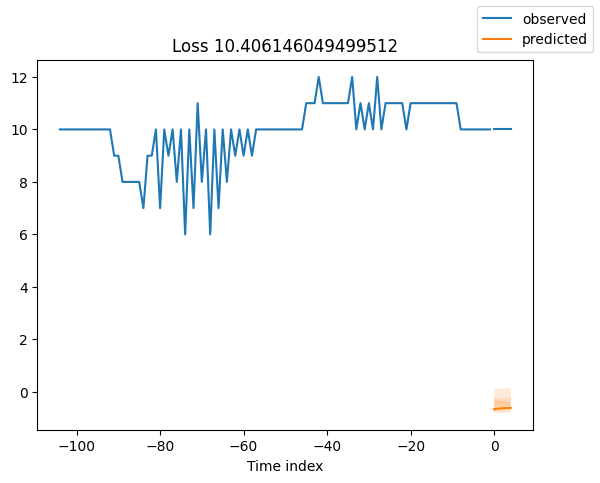

In [179]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)